In [ ]:
!pip install xlrd

In [ ]:
!pip install openpyxl

import pathlib

import pandas as pd
import numpy as np
import xlrd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import scipy.stats as stats
import tensorflow as tf

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install bayesian-optimization

In [ ]:
PY_DATOS_REALES_EST_SA=pd.read_excel("/content/drive/MyDrive/Datos/Copia de 4 Variables. Datos reales estandarizados sin atípicos (z-score).xlsx", sheet_name='Datos sin atipicos', header=0, index_col=0, usecols='A, B, C, D, E')
PY_DATOS_REALES_EST_SA

,Días,Área,PY_VC_PCA,Valor_Proyecto
#,,,,
1,0.199969,-0.224328,-0.670771,-0.563421
2,0.199969,-0.224328,-0.670771,-0.545120
3,0.199969,-0.222966,-0.670771,-0.544601
4,0.199969,-0.222966,-0.670771,-0.532932
5,1.478731,-0.182279,-0.670771,-0.532623
...,...,...,...,...
121,-0.699160,-0.219754,-1.883419,-0.617652
122,-0.659199,-0.223679,-1.883419,-0.604545
123,-0.579276,-0.224410,-1.883419,-0.584883


In [ ]:
PY_DATOS_REALES_EST_SA.describe()

,Días,Área,PY_VC_PCA,Valor_Proyecto
count,115.000000,115.000000,115.000000,115.000000
mean,-0.082193,-0.098454,-0.089025,-0.097465
std,0.780387,0.605987,1.861373,0.706249
min,-0.918948,-0.224417,-1.932311,-0.682176
25%,-0.669189,-0.224096,-1.883419,-0.587202
50%,-0.359489,-0.222363,-0.670771,-0.410561
75%,0.219950,-0.203633,0.739387,0.150954
max,3.576699,4.300396,3.524117,2.571424


In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, ReLU, ELU, Activation
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from bayes_opt import BayesianOptimization
from scipy.stats import spearmanr
import random

# Fijar la semilla para reproducibilidad
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Función personalizada para calcular SSE
def sse(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_true - y_pred))

# Función personalizada para calcular SAE
def sae(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true - y_pred))

# Función personalizada para calcular el coeficiente de determinación R^2
def r2_keras(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

# Función personalizada para calcular el coeficiente de correlación de Pearson
def pearson_correlation(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    x = y_true - tf.reduce_mean(y_true)
    y = y_pred - tf.reduce_mean(y_pred)
    r_num = tf.reduce_sum(x * y)
    r_den = tf.sqrt(tf.reduce_sum(tf.square(x)) * tf.reduce_sum(tf.square(y)))
    return r_num / (r_den + tf.keras.backend.epsilon())

# Función para calcular RMSE
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Seleccionar las columnas relevantes para la predicción de 'Valor_Proyecto'
data = PY_DATOS_REALES_EST_SA[['Días', 'Área', 'PY_VC_PCA', 'Valor_Proyecto']]
X = data.drop('Valor_Proyecto', axis=1).values
y = data['Valor_Proyecto'].values

# Dividir los datos en entrenamiento y validación con una semilla fija
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Función que entrena el modelo y devuelve la pérdida final, el historial y el modelo
def train_model_with_params(units_1, units_2, learning_rate):
    model = Sequential([
        Dense(int(units_1), input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('relu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(int(units_2), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('relu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(1, activation='linear')
    ])

    # Mantener el resto del código igual
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate), #---------------------------------
                  loss='mean_squared_error',                                #--------------------------------------
                  metrics=['mae', 'mse', rmse, sse, sae, r2_keras, pearson_correlation, tf.keras.losses.Huber(name='huber_loss')])

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) #-----------------------------------50
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000,                      #-----------------------------1000
                        batch_size=64,
                        callbacks=[early_stopping, reduce_lr, checkpoint],
                        verbose=1)

    return -history.history['val_loss'][-1], history, model

# Función solo para la optimización bayesiana (retorna solo la pérdida)
def train_model_for_optimization(units_1, units_2, learning_rate):

    val_loss, _, _ = train_model_with_params(units_1, units_2, learning_rate)
    return val_loss

# Definir los límites para la optimización
pbounds = {
    'units_1': (5, 100),
    'units_2': (5, 100),
    'learning_rate': (0.0001, 0.01)
}

# Crear una instancia de BayesianOptimization con semilla
optimizer = BayesianOptimization(
    f=train_model_for_optimization,
    pbounds=pbounds,
    random_state=42,  # Fijar la semilla para la optimización bayesiana
    verbose=2
)

# Ejecutar la optimización
optimizer.maximize(init_points=20, n_iter=20) #------------------------ 20

# Recuperar los mejores hiperparámetros
best_params = optimizer.max['params']

# Redondear los valores de las unidades a enteros para las capas
best_params['units_1'] = int(round(best_params['units_1']))
best_params['units_2'] = int(round(best_params['units_2']))

print("Mejores parámetros encontrados:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Entrenar el modelo con los mejores hiperparámetros encontrados y obtener el historial y el modelo
val_loss, history, model = train_model_with_params(
    best_params['units_1'],
    best_params['units_2'],
    best_params['learning_rate']
)

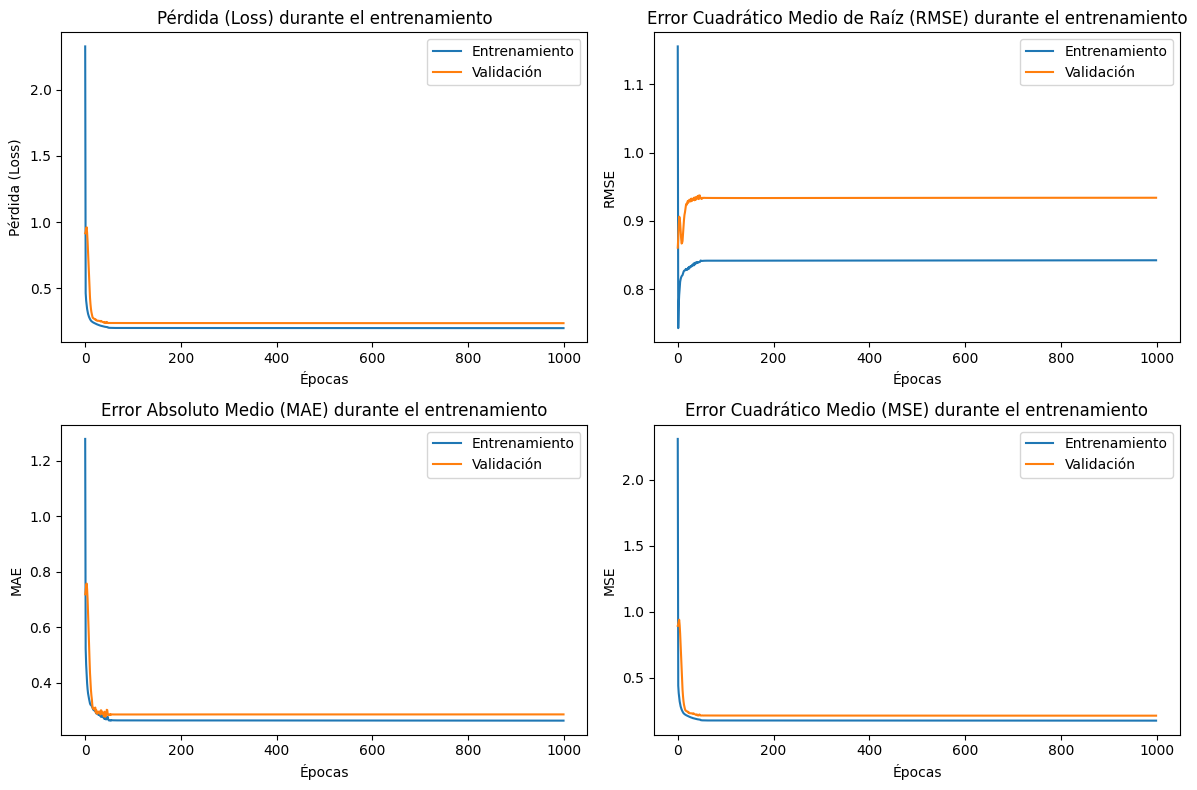

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


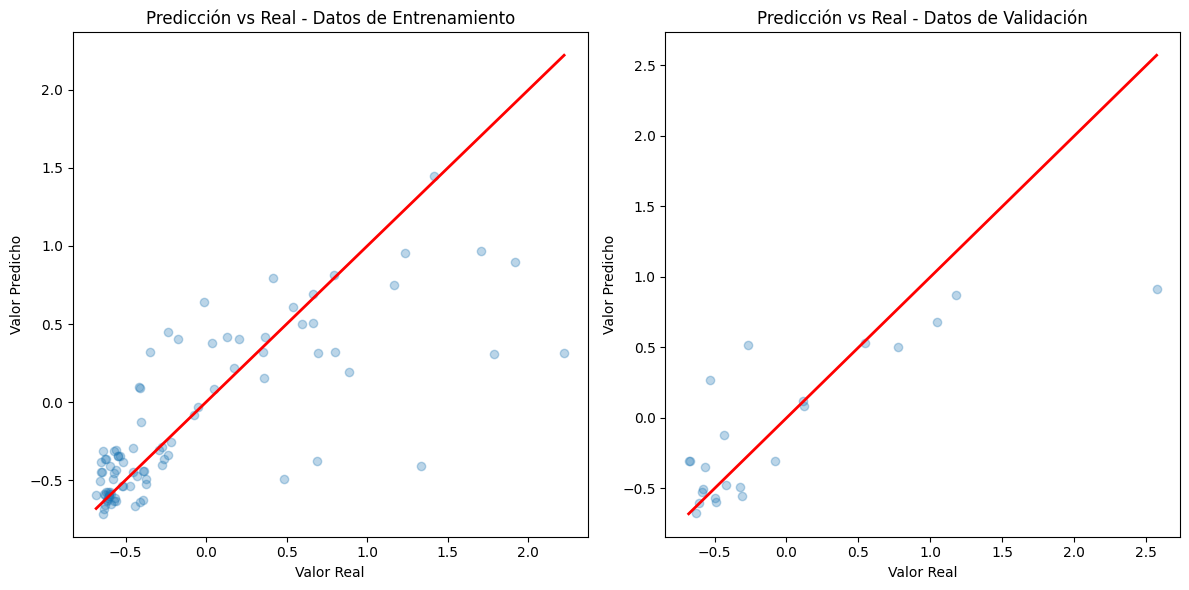


Métricas de entrenamiento:
MSE: 0.18939190115794335
RMSE: 0.43519179812807063
MAE: 0.24941697632565024
R^2: 0.5927605000165566
Correlación de Pearson: 5.663686935059488e-17
Correlación de Spearman: 0.7628724564813202
SSE: 6071.830415063219
SAE: 5185.149295935898
Media del error: 0.049027173367698865
Desviación estándar del error: 0.8455575702410197
Huber Loss (Entrenamiento): 0.07398819923400879

Métricas de validación:
MSE: 0.21272456280150742
RMSE: 0.4612207311055168
MAE: 0.2856508525034534
R^2: 0.6512241466014423
Correlación de Pearson: 1.208364531675049e-16
Correlación de Spearman: 0.7055335968379446
SSE: 461.38751182441075
SAE: 354.90892223866206
Media del error: 0.025186453546465593
Desviación estándar del error: 0.9335704342187445
Huber Loss (Validación): 0.09698157012462616
El punto de convergencia (mejor epoch): 998


In [ ]:
# Graficar las curvas de aprendizaje (entrenamiento y validación)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['rmse'], label='Entrenamiento')
plt.plot(history.history['val_rmse'], label='Validación')
plt.title('Error Cuadrático Medio de Raíz (RMSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Validación')
plt.title('Error Absoluto Medio (MAE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['mse'], label='Entrenamiento')
plt.plot(history.history['val_mse'], label='Validación')
plt.title('Error Cuadrático Medio (MSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar los datos entrenados vs reales y validados vs reales
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

plt.figure(figsize=(12, 6))

# Gráfico de datos de entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2)
plt.title('Predicción vs Real - Datos de Entrenamiento')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

# Gráfico de datos de validación
plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r', lw=2)
plt.title('Predicción vs Real - Datos de Validación')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.tight_layout()
plt.show()

# Función para calcular la media y desviación estándar
def calcular_media_desviacion(y_true, y_pred):
    diferencia = y_true - y_pred
    media = np.mean(diferencia)
    desviacion = np.std(diferencia)
    return media, desviacion

# Evaluar el modelo final en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)
pearson_train = pearson_correlation(y_train, y_train_pred).numpy()
spearman_train, _ = spearmanr(y_train, y_train_pred)  # Correlación de Spearman
sse_train = np.sum((y_train - y_train_pred) ** 2)
sae_train = np.sum(np.abs(y_train - y_train_pred))
media_train, desviacion_train = calcular_media_desviacion(y_train, y_train_pred)
huber_loss_train = history.history['huber_loss'][-1]

print("\nMétricas de entrenamiento:")
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"MAE: {mae_train}")
print(f"R^2: {r2_train}")
print(f"Correlación de Pearson: {pearson_train}")
print(f"Correlación de Spearman: {spearman_train}")
print(f"SSE: {sse_train}")
print(f"SAE: {sae_train}")
print(f"Media del error: {media_train}")
print(f"Desviación estándar del error: {desviacion_train}")
print(f"Huber Loss (Entrenamiento): {huber_loss_train}")

# Evaluar el modelo final en el conjunto de validación
mse_val = mean_squared_error(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)
pearson_val = pearson_correlation(y_val, y_val_pred).numpy()
spearman_val, _ = spearmanr(y_val, y_val_pred)  # Correlación de Spearman
sse_val = np.sum((y_val - y_val_pred) ** 2)
sae_val = np.sum(np.abs(y_val - y_val_pred))
media_val, desviacion_val = calcular_media_desviacion(y_val, y_val_pred)
huber_loss_val = history.history['val_huber_loss'][-1]

print("\nMétricas de validación:")
print(f"MSE: {mse_val}")
print(f"RMSE: {rmse_val}")
print(f"MAE: {mae_val}")
print(f"R^2: {r2_val}")
print(f"Correlación de Pearson: {pearson_val}")
print(f"Correlación de Spearman: {spearman_val}")
print(f"SSE: {sse_val}")
print(f"SAE: {sae_val}")
print(f"Media del error: {media_val}")
print(f"Desviación estándar del error: {desviacion_val}")
print(f"Huber Loss (Validación): {huber_loss_val}")

# Imprimir la época en la que se alcanzó la mejor validación
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"El punto de convergencia (mejor epoch): {best_epoch}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


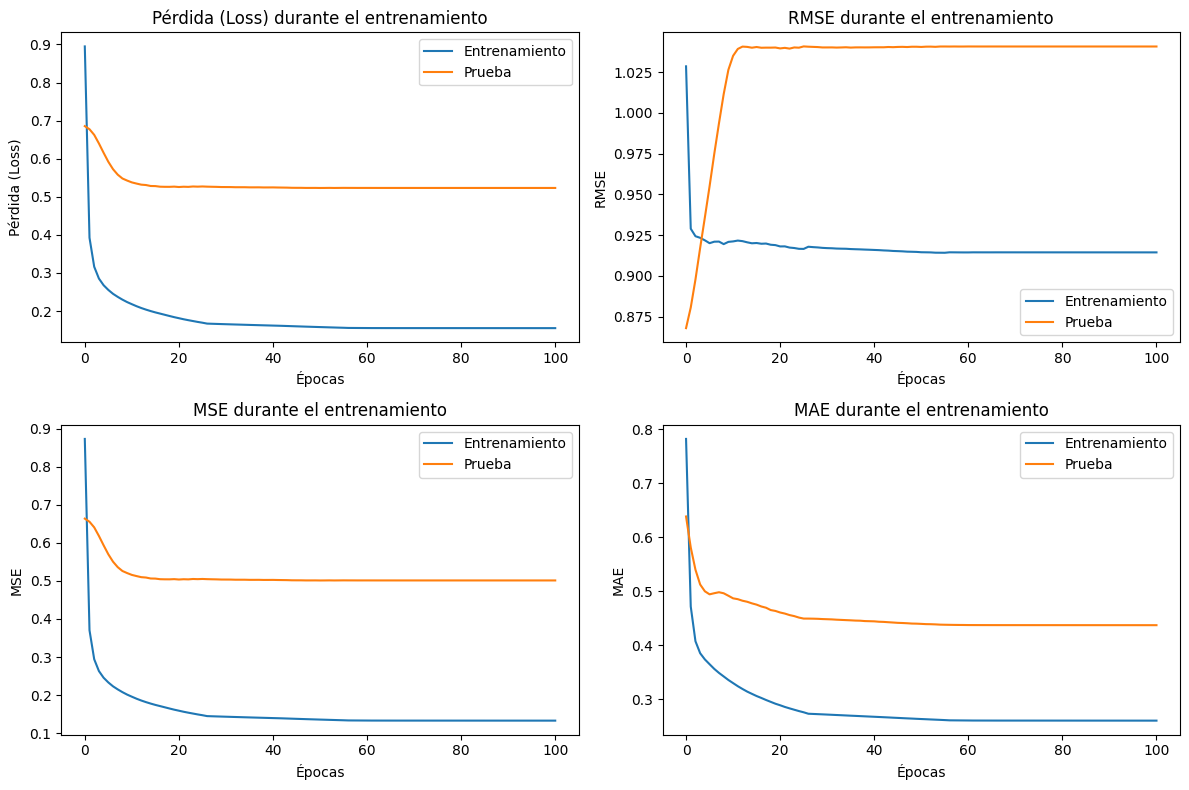

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


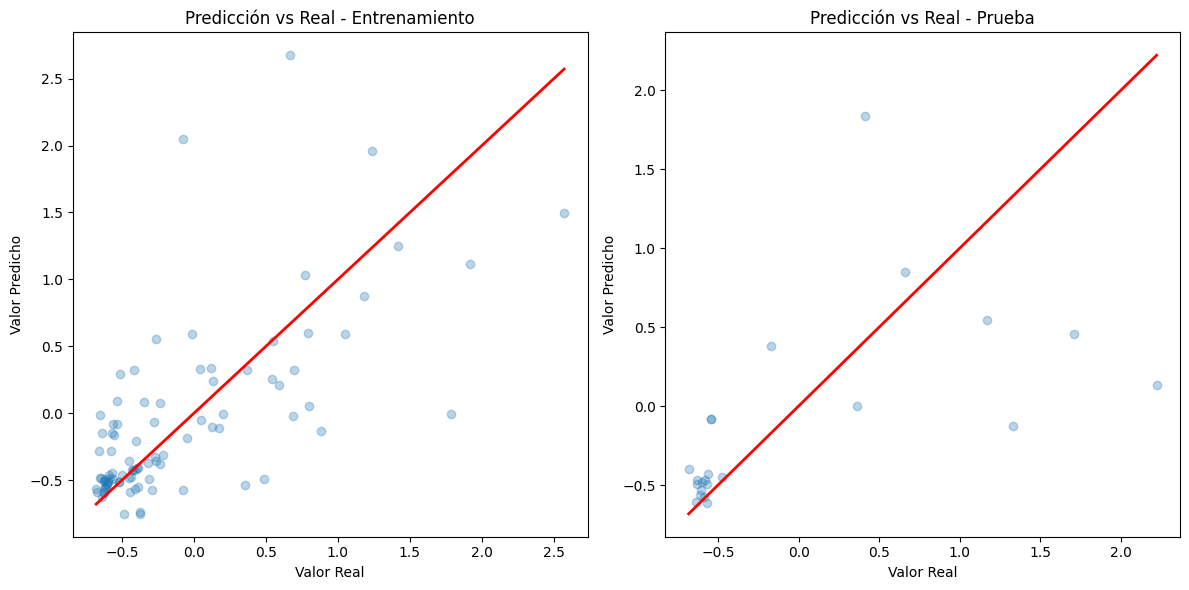

Simulación de cross_val_score (MSE): 0.2948423306980211 ± 0.11267205855819769
Simulación de cross_val_score (RMSE): 0.5340145214898334 ± 0.09834033524452396
Simulación de cross_val_score (MAE): 0.3657571357268043 ± 0.05576813405474966
SSE promedio: 414.07335239581397
SAE promedio: 342.004209411071
R^2 promedio: 0.3676540246661334, Desviación estándar: 0.17854255102678934
Correlación de Pearson promedio: -1.1435123098855564e-16, Desviación estándar: 6.396856916189487e-17
Correlación de Spearman promedio: 0.6778281162327453, Desviación estándar: 0.060579858909988175
Huber Loss promedio: 0.08875060603022575, Desviación estándar: 0.0298433041064013
El punto de convergencia (mejor epoch): 51


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
import numpy as np

# Definir el número de pliegues (k) para la validación cruzada
k = 5

# Crear un objeto KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Inicializar listas para almacenar las métricas en cada pliegue
mse_scores = []
mae_scores = []
sse_scores = []
sae_scores = []
r2_scores = []
pearson_scores = []
rmse_scores = []
spearman_scores = []
huber_loss_scores = []

# Iterar sobre los pliegues
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = Sequential([
        Dense(int(best_params['units_1']), input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('relu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(int(best_params['units_2']), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('relu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(1, activation='linear')
    ])

    # Función personalizada para calcular SSE
    def sse(y_true, y_pred):
        return tf.reduce_sum(tf.square(y_true - y_pred))

    # Función personalizada para calcular SAE
    def sae(y_true, y_pred):
        return tf.reduce_sum(tf.abs(y_true - y_pred))

    # Función personalizada para calcular el coeficiente de determinación R^2
    def r2_keras(y_true, y_pred):
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
        ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
        return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

    # Función personalizada para calcular el coeficiente de correlación de Pearson
    def pearson_correlation(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float64)  # Cast y_true to float64
        y_pred = tf.cast(y_pred, tf.float64)  # Cast y_pred to float64
        x = y_true - tf.reduce_mean(y_true)
        y = y_pred - tf.reduce_mean(y_pred)
        r_num = tf.reduce_sum(x * y)
        r_den = tf.sqrt(tf.reduce_sum(tf.square(x)) * tf.reduce_sum(tf.square(y)))
        return r_num / (r_den + tf.keras.backend.epsilon())

    # Función para calcular RMSE
    def rmse(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

    model.compile(optimizer=tf.keras.optimizers.SGD(best_params['learning_rate']), #-----------------------------
                  loss='mean_squared_error',              #-----------------------------------------
                  metrics=['mae', 'mse', rmse, sse, sae, r2_keras, pearson_correlation, tf.keras.losses.Huber(name='huber_loss')])

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) #--------------------50
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000,                              #--------------------1000
                        batch_size=64,
                        callbacks=[early_stopping, reduce_lr],
                        verbose=0)

    # Predecir con el modelo en el conjunto de validación
    y_pred = model.predict(X_val)

    # Calcular las métricas de error
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    sse = np.sum((y_val - y_pred) ** 2)
    sae = np.sum(np.abs(y_val - y_pred))
    r2 = r2_score(y_val, y_pred)
    pearson = pearson_correlation(y_val, y_pred).numpy()
    spearman, _ = spearmanr(y_val, y_pred)
    huber_loss = history.history['huber_loss'][-1]

    # Almacenar las métricas en las listas
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    sse_scores.append(sse)
    sae_scores.append(sae)
    r2_scores.append(r2)
    pearson_scores.append(pearson)
    spearman_scores.append(spearman)
    huber_loss_scores.append(huber_loss)

import matplotlib.pyplot as plt

# Graficar las curvas de aprendizaje (pérdida, huber_loss, mse, mae)
plt.figure(figsize=(12, 8))

# Pérdida (Loss)
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Prueba')
plt.title('Pérdida (Loss) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()

# Huber Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['rmse'], label='Entrenamiento')
plt.plot(history.history['val_rmse'], label='Prueba')
plt.title('RMSE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('RMSE')
plt.legend()

# MSE
plt.subplot(2, 2, 3)
plt.plot(history.history['mse'], label='Entrenamiento')
plt.plot(history.history['val_mse'], label='Prueba')
plt.title('MSE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

# MAE
plt.subplot(2, 2, 4)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Prueba')
plt.title('MAE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Gráfico de predicciones en los datos de entrenamiento
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2)
plt.title('Predicción vs Real - Entrenamiento')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r', lw=2)
plt.title('Predicción vs Real - Prueba')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.tight_layout()
plt.show()

# Calcular estadísticas de las métricas
mse_mean = np.mean(mse_scores)
mse_std = np.std(mse_scores)
rmse_mean = np.mean(rmse_scores)
rmse_std = np.std(rmse_scores)
mae_mean = np.mean(mae_scores)
mae_std = np.std(mae_scores)
sse_mean = np.mean(sse_scores)
sae_mean = np.mean(sae_scores)
r2_mean = np.mean(r2_scores)
r2_std = np.std(r2_scores)
pearson_mean = np.mean(pearson_scores)
pearson_std = np.std(pearson_scores)
spearman_mean = np.mean(spearman_scores)
spearman_std = np.std(spearman_scores)
huber_loss_mean = np.mean(huber_loss_scores)
huber_loss_std = np.std(huber_loss_scores)

# Simular cross_val_score al imprimir el promedio de las métricas
print(f"Simulación de cross_val_score (MSE): {mse_mean} ± {mse_std}")
print(f"Simulación de cross_val_score (RMSE): {rmse_mean} ± {rmse_std}")
print(f"Simulación de cross_val_score (MAE): {mae_mean} ± {mae_std}")
print(f"SSE promedio: {sse_mean}")
print(f"SAE promedio: {sae_mean}")
print(f"R^2 promedio: {r2_mean}, Desviación estándar: {r2_std}")
print(f"Correlación de Pearson promedio: {pearson_mean}, Desviación estándar: {pearson_std}")
print(f"Correlación de Spearman promedio: {spearman_mean}, Desviación estándar: {spearman_std}")
print(f"Huber Loss promedio: {huber_loss_mean}, Desviación estándar: {huber_loss_std}")

# Imprimir la época en la que se alcanzó la mejor validación
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"El punto de convergencia (mejor epoch): {best_epoch}")